# Dataset para DEA

Prepara inputs y outputs por estación (DMU) y por caso (l-v pico, lv normal y FDS.

Reglas clave:
- Picos LV: umbral =promedio de mas de 150 viajes
- Timestamps:
  - Viajes: fecha + hora locales, combinadas.

Inputs (3):
- % de capacidad usable
- densidad_vecina_300m (suma de capacidad de bicis vecinas a <300 m hacer pruebas)
- eventos rebalanceo

Outputs (4):
- densidaddeactividad en la estacion_franja
- prevalencia_salidas_share (mucha correlacion)quitar
- nivel_servicio (arbitrario hacer pruebas)
- atractividad_activa

lista de colonias mas abajo

In [73]:
import pandas as pd
import unicodedata
import numpy as np
from datetime import time

In [74]:
COLONIAS = ["San Miguel Chapultepec", "Hipodromo Condesa","Condesa"]
#para caso a correr escoger "pico", "norm" o "fds"
#case ="lvpico"
case ="lvnorm"
#case = "fds"
print("Usando colonias:", COLONIAS)
print("Usando datos de el caso:", case)

Usando colonias: ['San Miguel Chapultepec', 'Hipodromo Condesa', 'Condesa']
Usando datos de el caso: lvnorm


In [75]:
import pandas as pd

df1 = pd.read_csv("../data/raw/snapshots_dia1.csv")      
df2 = pd.read_csv("../data/raw/tesis2.csv")        

# junto mis dos archivos de snapshots
merged = pd.concat([df1, df2], ignore_index=True)


merged.to_csv("../data/raw/snapshots.csv", index=False)     

len(merged)

766364

In [76]:
#Datos de viajes y cicloestaciones
viajes_df = pd.read_csv('../data/raw/viajes_04.csv', encoding='latin-1', dtype=str)
estaciones_df = pd.read_csv('../data/raw/estaciones_catalogo.csv', encoding='latin-1', dtype=str)
snaps_df= pd.read_csv('../data/raw/snapshots.csv', encoding='latin-1', dtype=str)
info_df= pd.read_csv('../data/raw/station_info.csv', encoding='latin-1', dtype=str)

In [77]:
#estandarizar columnas
def estandariza_cols(df):
    out = df.copy()
    out.columns = (
        out.columns.str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^\w]", "", regex=True)  # quita símbolos
    )
    # quita acentos 
    out.columns = [
        "".join(c for c in unicodedata.normalize("NFKD", s) if not unicodedata.combining(c))
        for s in out.columns
    ]
    return out

viajes_df     = estandariza_cols(viajes_df)
estaciones_df = estandariza_cols(estaciones_df)
snaps_df      = estandariza_cols(snaps_df)
info_df       = estandariza_cols(info_df)

# homologa nombres 
estaciones_df = estaciones_df.rename(columns={"latitud":"lat", "longitud":"lon"})


limpio a solo columnas que necesito

In [78]:
#station id es dif a numero de estación que es lo que usan los otros datasets por lo que hago join y luego borro station id y el resto de las columnas que no necesito
snaps_df["station_id"] = snaps_df["station_id"].str.strip()
info_df["station_id"]  = info_df["station_id"].str.strip()

snaps_enriq = snaps_df.merge(
    info_df[["station_id", "short_name"]].drop_duplicates("station_id"),
    on="station_id",
    how="left"
).rename(columns={"short_name": "num_cicloe"})

snaps_columnas_drop =["station_id","name","address","is_renting","is_returning","last_reported"]
snaps_new = snaps_enriq.drop(columns=snaps_columnas_drop, errors="ignore")

#ahora junto columnas de viajes fecha y hora en una misma date time pq es más facil de manejar y dropeo columnas genero y edad
for c in ["fecha_retiro","hora_retiro","fecha_arribo","hora_arribo"]:
    viajes_df[c] = viajes_df[c].astype(str).str.strip()

viajes_df["fecha_hora_retiro"] = pd.to_datetime(
    viajes_df["fecha_retiro"] + " " + viajes_df["hora_retiro"],
    format="%d/%m/%Y %H:%M:%S", errors="coerce"
)

viajes_df["fecha_hora_arribo"] = pd.to_datetime(
    viajes_df["fecha_arribo"] + " " + viajes_df["hora_arribo"],
    format="%d/%m/%Y %H:%M:%S", errors="coerce"
)
viajes_columnas_drop =["genero_usuario","edad_usuario","fecha_retiro","hora_retiro","fecha_arribo","hora_arribo"]
viajes_new = viajes_df.drop(columns=viajes_columnas_drop, errors="ignore")

#igual limpio estaciones y le agrego columna de capacidad ( esta en snaps )
estaciones_columnas_drop=["sistema","calle_prin","calle_secu"]
estaciones_new = estaciones_df.drop(columns=estaciones_columnas_drop, errors="ignore")

# capacity por estación (tomamos el máximo por si varía en snapshots)
snaps_new["num_cicloe"] = pd.to_numeric(snaps_new["num_cicloe"], errors="coerce")
snaps_new["capacity"]  = pd.to_numeric(snaps_new["capacity"],  errors="coerce")
cap_por_est = snaps_new.groupby("num_cicloe", as_index=False)["capacity"].max()

# join a estaciones por num_cicloe
estaciones_new["num_cicloe"] = pd.to_numeric(estaciones_new["num_cicloe"], errors="coerce")
estaciones_new = estaciones_new.merge(cap_por_est, on="num_cicloe", how="left")

cap_map = cap_por_est.set_index("num_cicloe")["capacity"]
snaps_new.head()


snaps_new["run_ts"] = pd.to_datetime(snaps_new["run_ts"], errors="coerce")

# Mantener solo servicio: 05:00–24:00 y 00:00–00:30
mask_servicio = (snaps_new["run_ts"].dt.time >= time(5,0)) | (snaps_new["run_ts"].dt.time <= time(0,30))
snaps_new = snaps_new.loc[mask_servicio].copy()
viajes_new['duracion_viaje'] = (viajes_new['fecha_hora_arribo'] - viajes_new['fecha_hora_retiro']).dt.total_seconds() / 60

In [79]:
#limpiar columnas
def normaliza_cicloe_inplace(df, columnas):
    # permite string o lista/tupla
    if isinstance(columnas, str):
        columnas = [columnas]

    for col in columnas:
        if col not in df.columns:
            raise KeyError(f"{col} no está en df.columns")
        df[col] = (
            pd.Series(df[col], dtype="string")
              .str.strip()
              .str.replace(r"[—–−]", "-", regex=True)      
              .str.extract(r"(\d+)", expand=False)        
              .pipe(pd.to_numeric, errors="coerce")
              .astype("Int64")
        )
normaliza_cicloe_inplace(snaps_new,"num_cicloe")
normaliza_cicloe_inplace(estaciones_new,"num_cicloe")
normaliza_cicloe_inplace(viajes_new,["ciclo_estacion_retiro","ciclo_estacionarribo"])


densidad de bicis alrededor de una estación

In [80]:

RADIO_DENSIDAD = 300.0  # m
#me aseguro q son numericos
for c in ["lat","lon","capacity"]:
    estaciones_new[c] = pd.to_numeric(estaciones_new[c], errors="coerce")

R = 6371000.0  # m
valid = estaciones_new["lat"].notna() & estaciones_new["lon"].notna()

lat = np.radians(estaciones_new.loc[valid, "lat"].to_numpy())
lon = np.radians(estaciones_new.loc[valid, "lon"].to_numpy())

# Si capacidad tiene NA, se vuelve 0 para la suma
caps = np.nan_to_num(estaciones_new.loc[valid, "capacity"].to_numpy(dtype=float), nan=0.0)

# Distancias Haversine
dlat = lat[:, None] - lat[None, :]
dlon = lon[:, None] - lon[None, :]
a = np.sin(dlat/2)**2 + np.cos(lat)[:, None]*np.cos(lat)[None, :]*np.sin(dlon/2)**2
dist_m = 2 * R * np.arcsin(np.sqrt(a))

# Suma de capacidades dentro de 300 m (incluye la propia, dist=0)
mask = dist_m <= RADIO_DENSIDAD
dens = np.where(mask, caps[None, :], 0.0).sum(axis=1)

estaciones_new["densidad_300m"] = np.nan
estaciones_new.loc[valid, "densidad_300m"] = dens

# Si alguna fila no tiene lat/lon, al menos su propia capacidad
estaciones_new["densidad_300m"] = estaciones_new["densidad_300m"].fillna(estaciones_new["capacity"])


filtro colonias que voy a usar para tener los numeros de las estaciones

In [81]:
estaciones_dmus = estaciones_new[estaciones_new["colonia"].isin(COLONIAS)].reset_index(drop=True)
dmus= estaciones_dmus["num_cicloe"].dropna().unique().tolist()
len(dmus)

28

In [82]:
estaciones_dmus.head()

,num_cicloe,colonia,alcaldia,lat,lon,sitio_de_e,estatus,capacity,densidad_300m
0,258,Condesa,Cuauhtemoc,19.416530,-99.179044,Banqueta,Instalada,33.0,48.0
1,447,Condesa,Cuauhtemoc,19.418879,-99.176854,Arroyo,Instalada,27.0,122.0
2,49,Condesa,Cuauhtemoc,19.416890,-99.175620,Banqueta,Instalada,39.0,129.0
3,50,Condesa,Cuauhtemoc,19.416886,-99.173591,Arroyo,Instalada,27.0,168.0
4,53,Condesa,Cuauhtemoc,19.414823,-99.178353,Arroyo,Instalada,15.0,87.0


In [83]:
viajes_dmu = viajes_new.loc[
    viajes_new["ciclo_estacion_retiro"].isin(dmus) |
    viajes_new["ciclo_estacionarribo"].isin(dmus)
]
snaps_dmu = snaps_new[snaps_new["num_cicloe"].isin(dmus)].reset_index(drop=True)


busco horas pico

In [84]:
# --- Parámetros ---
UMBRAL_PICO = 125 
# Arma 'flujo' con timestamps de retiros y arribos
flujo = pd.DataFrame({
    "ts": pd.to_datetime(
        pd.concat([viajes_dmu["fecha_hora_retiro"], viajes_dmu["fecha_hora_arribo"]], ignore_index=True),
        errors="coerce"
    )
}).dropna(subset=["ts"])
flujo["tipo_dia"] = np.where(flujo["ts"].dt.weekday <= 4, "LV", "FDS")

# Throughput promedio por slot de 15 min
def avg_thr(df):
    if df.empty:
        return pd.Series(dtype=float)
    s = df.set_index("ts").sort_index().resample("15min").size()
    return s.groupby(s.index.time).mean()

thr_lv  = avg_thr(flujo[flujo["tipo_dia"] == "LV"])
thr_fds = avg_thr(flujo[flujo["tipo_dia"] == "FDS"])

# Slots pico con umbral fijo
def time_to_slot(t): return t.hour*4 + t.minute//15
pico_slots = set()
if not thr_lv.empty:
    pico_slots = {time_to_slot(t) for t, v in thr_lv.items() if v > UMBRAL_PICO}


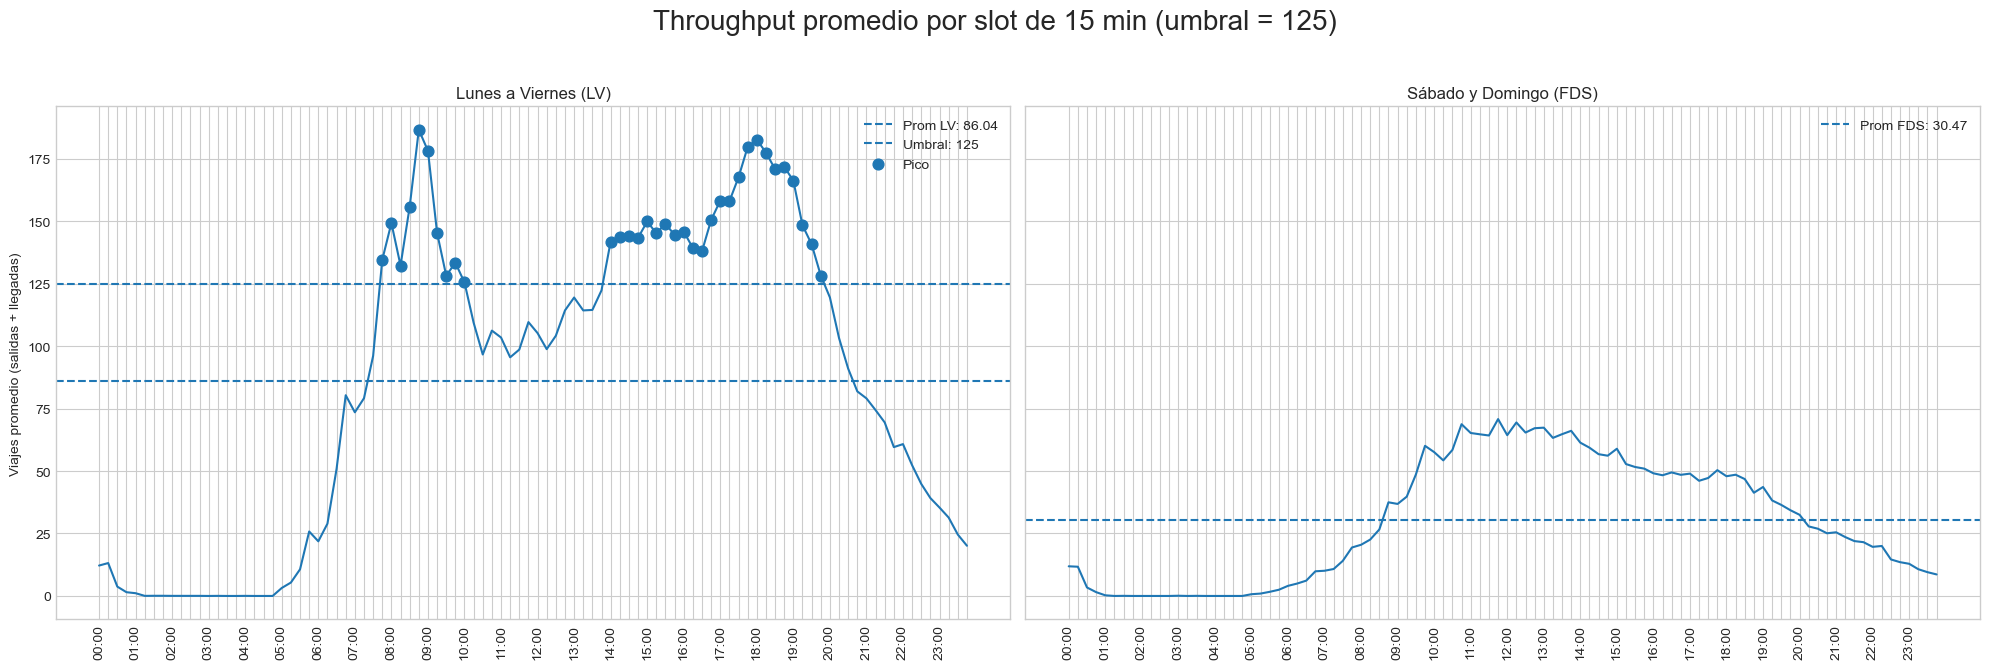

Franjas Pico LV:
  -> Franja 1: 07:45-10:15
  -> Franja 2: 14:00-20:00


In [85]:
# Gráfica LV/FDS 
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle(f'Throughput promedio por slot de 15 min (umbral = {UMBRAL_PICO})', fontsize=20)

# LV
if not thr_lv.empty:
    x_lv = [t.strftime("%H:%M") for t in thr_lv.index]
    y_lv = thr_lv.values
    axes[0].plot(x_lv, y_lv)
    axes[0].axhline(thr_lv.mean(), ls='--', label=f'Prom LV: {thr_lv.mean():.2f}')
    axes[0].axhline(UMBRAL_PICO, ls='--', label=f'Umbral: {UMBRAL_PICO}')
    if pico_slots:
        idx_pico = [i for i, t in enumerate(thr_lv.index) if time_to_slot(t) in pico_slots]
        axes[0].scatter([x_lv[i] for i in idx_pico], thr_lv.iloc[idx_pico], s=60, zorder=3, label='Pico')
    axes[0].set_title('Lunes a Viernes (LV)')
    axes[0].set_ylabel('Viajes promedio (salidas + llegadas)')
    axes[0].legend()
else:
    axes[0].set_title('Sin datos LV')

# FDS
if not thr_fds.empty:
    x_fds = [t.strftime("%H:%M") for t in thr_fds.index]
    axes[1].plot(x_fds, thr_fds.values)
    axes[1].axhline(thr_fds.mean(), ls='--', label=f'Prom FDS: {thr_fds.mean():.2f}')
    axes[1].set_title('Sábado y Domingo (FDS)')
    axes[1].legend()
else:
    axes[1].set_title('Sin datos FDS')

#  solo cada hora
for ax in axes:
    ax.tick_params(axis='x', rotation=90)
    labels = ax.get_xticklabels()
    for i, lbl in enumerate(labels):
        if i % 4 != 0: lbl.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# imprime franjas
if pico_slots:
    slots = sorted(pico_slots)
    runs, start = [], slots[0]
    prev = start
    for s in slots[1:]:
        if s == prev + 1: prev = s
        else:
            runs.append((start, prev)); start = prev = s
    runs.append((start, prev))
    print("Franjas Pico LV:")
    for i, (s0, s1) in enumerate(runs, 1):
        ini_h = f"{(s0*15)//60:02d}:{(s0*15)%60:02d}"
        fin_h = f"{((s1+1)*15)//60:02d}:{((s1+1)*15)%60:02d}"
        print(f"  -> Franja {i}: {ini_h}-{fin_h}")


In [86]:
# 1) Franjas pico [min_ini,min_fin) desde pico_slots
franjas_pico = []
if pico_slots:
    slots = sorted(pico_slots)
    s0 = p = slots[0]
    for s in slots[1:]:
        if s == p + 1: p = s
        else: franjas_pico.append((s0*15, (p+1)*15)); s0 = p = s
    franjas_pico.append((s0*15, (p+1)*15))

def en_pico_lv(ts):
    if pd.isna(ts) or ts.weekday() > 4:  # no LV
        return False
    mins = ts.hour*60 + ts.minute
    return any(a <= mins < b for a, b in franjas_pico)

# flags por viaje (retiro/arribo) para LV y pico
lv_ret   = viajes_dmu["fecha_hora_retiro"].dt.weekday <= 4
lv_arr   = viajes_dmu["fecha_hora_arribo"].dt.weekday <= 4

ret_pico = viajes_dmu["fecha_hora_retiro"].apply(en_pico_lv)
arr_pico = viajes_dmu["fecha_hora_arribo"].apply(en_pico_lv)

# reglas
lv_pico = (lv_ret & ret_pico) | (lv_arr & arr_pico)
lv_any  = lv_ret | lv_arr

viajes_dmu["case"] = np.select([lv_pico, lv_any], ["L-V Pico", "L-V norm"], default="FDS")

viajes_dmu["case"].value_counts()


/var/folders/6t/lc_ggpnj5zqbk9vlvsbhf6fr0000gn/T/ipykernel_19798/788133358.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viajes_dmu["case"] = np.select([lv_pico, lv_any], ["L-V Pico", "L-V norm"], default="FDS")


case
L-V Pico    80829
L-V norm    43140
FDS         33585
Name: count, dtype: int64

ya teniendo las horas pico puedo separar mis datos en 3


para algunos outputs tengo que separar viajes en retiros y arribos


In [87]:
viajes_salidas = viajes_dmu.rename(columns={"ciclo_estacion_retiro": "num_cicloe"})
viajes_salidas = viajes_salidas.drop(
    columns=["fecha_hora_arribo"],
    errors="ignore")
viajes_salidas_dmu = viajes_salidas[viajes_salidas["num_cicloe"].isin(dmus)].reset_index(drop=True)

viajes_arribos = viajes_dmu.rename(columns={"ciclo_estacionarribo": "num_cicloe"})

viajes_arribos = viajes_arribos.drop(
    columns=["fecha_hora_retiro"],
    errors="ignore")

viajes_arribos_dmu = viajes_arribos[viajes_arribos["num_cicloe"].isin(dmus)].reset_index(drop=True)


In [88]:
# run_ts → datetime local y quitar naT
snaps_dmu["ts"] = (
    pd.to_datetime(snaps_dmu["run_ts"], errors="coerce", utc=True)
      .dt.tz_convert("America/Mexico_City").dt.tz_localize(None)
)
snaps_dmu = snaps_dmu.dropna(subset=["ts"])

# minutos del día y  L–V
mins = snaps_dmu["ts"].dt.hour*60 + snaps_dmu["ts"].dt.minute
lv   = snaps_dmu["ts"].dt.weekday <= 4

# en_pico segun franjas_pico (lista de (ini, fin) en minutos)
en_pico = pd.Series(False, index=snaps_dmu.index)
for a, b in franjas_pico:               # [a, b)
    en_pico |= (mins >= a) & (mins < b)

#case: L-V Pico > L-V norm > FDS
snaps_dmu["case"] = np.select(
    [lv & en_pico, lv],
    ["L-V Pico", "L-V norm"],
    default="FDS"
)

# chequeo 
snaps_dmu.head()


,run_ts,lat,lon,capacity,bikes_avail,docks_avail,is_installed,pct_full,num_cicloe,ts,case
0,2025-09-11 13:32:05-06:00,19.416795,-99.192508,39,26,12,1,0.6842105263,710,2025-09-11 13:32:05,L-V norm
1,2025-09-11 13:32:05-06:00,19.409859,-99.179565,31,9,13,1,0.4090909091,72,2025-09-11 13:32:05,L-V norm
2,2025-09-11 13:32:05-06:00,19.41181373,-99.17595729,23,6,15,1,0.2857142857,67,2025-09-11 13:32:05,L-V norm
3,2025-09-11 13:32:05-06:00,19.41689,-99.17562,39,6,27,1,0.1818181818,49,2025-09-11 13:32:05,L-V norm
4,2025-09-11 13:32:05-06:00,19.411825,-99.178456,27,8,16,1,0.3333333333,66,2025-09-11 13:32:05,L-V norm


Van a ser 3 deas, uno para lv pico, uno para lv norm y uno para fds. cree un dataser individual apra cada uno para que este más facil distinguir

In [89]:
pico = ["L-V Pico"]
norm = ["L-V norm"]
fds  = ["FDS"]

snaps_dmu_lvpico        = snaps_dmu[snaps_dmu["case"].isin(pico)].reset_index(drop=True)
viajes_dmu_lvpico       = viajes_dmu[viajes_dmu["case"].isin(pico)].reset_index(drop=True)
viajes_salidas_dmu_lvpico = viajes_salidas_dmu[viajes_salidas_dmu["case"].isin(pico)].reset_index(drop=True)
viajes_arribos_dmu_lvpico = viajes_arribos_dmu[viajes_arribos_dmu["case"].isin(pico)].reset_index(drop=True)

snaps_dmu_lvnorm        = snaps_dmu[snaps_dmu["case"].isin(norm)].reset_index(drop=True)
viajes_dmu_lvnorm       = viajes_dmu[viajes_dmu["case"].isin(norm)].reset_index(drop=True)
viajes_salidas_dmu_lvnorm = viajes_salidas_dmu[viajes_salidas_dmu["case"].isin(norm)].reset_index(drop=True)
viajes_arribos_dmu_lvnorm = viajes_arribos_dmu[viajes_arribos_dmu["case"].isin(norm)].reset_index(drop=True)

snaps_dmu_fds           = snaps_dmu[snaps_dmu["case"].isin(fds)].reset_index(drop=True)
viajes_dmu_fds          = viajes_dmu[viajes_dmu["case"].isin(fds)].reset_index(drop=True)
viajes_salidas_dmu_fds  = viajes_salidas_dmu[viajes_salidas_dmu["case"].isin(fds)].reset_index(drop=True)
viajes_arribos_dmu_fds  = viajes_arribos_dmu[viajes_arribos_dmu["case"].isin(fds)].reset_index(drop=True)


In [90]:
viajes_case         = globals()[f"viajes_dmu_{case}"]
viajes_salidas_case = globals()[f"viajes_salidas_dmu_{case}"]
viajes_arribos_case = globals()[f"viajes_arribos_dmu_{case}"]
snaps_case          = globals()[f"snaps_dmu_{case}"]

In [91]:

# INPUT 1  pct_cap_usable = 1 - promedio( (cap - bikes - docks)/cap )

sn = snaps_case.copy()
sn["num_cicloe"]  = pd.to_numeric(sn["num_cicloe"], errors="coerce").astype("Int64")
sn["capacity"]    = pd.to_numeric(sn.get("capacity"),    errors="coerce")
sn["bikes_avail"] = pd.to_numeric(sn.get("bikes_avail"), errors="coerce")
sn["docks_avail"] = pd.to_numeric(sn.get("docks_avail"), errors="coerce")

# filas válidas y sin cap = 0
sn = sn.dropna(subset=["num_cicloe","capacity","bikes_avail","docks_avail"])
sn = sn[sn["capacity"] > 0]

# fracción fuera de servicio por corte (0–1), luego promedio por DMU
sn["oos_frac"] = ((sn["capacity"] - sn["bikes_avail"] - sn["docks_avail"]) / sn["capacity"]).clip(0, 1)
oos_rate = sn.groupby("num_cicloe", as_index=True)["oos_frac"].mean().rename("oos_rate")

# % de capacidad usable = 1 - % fuera de servicio
inputs_capacidad = (
    oos_rate.to_frame()
    .assign(pct_cap_usable = 1.0 - oos_rate)   # rango 0–1
    [["pct_cap_usable"]]
    .reset_index()
)
# -> inputs_capacidad: [num_cicloe, pct_cap_usable]


In [92]:
 #INPUT 2: densidad_vecina (ya calculada al principio y en estaciones_dmus)
# arma la tabla de input 2 para los DMUs de mi caso
snaps_case = snaps_case.copy()
snaps_case["num_cicloe"]   = pd.to_numeric(snaps_case["num_cicloe"], errors="coerce").astype("Int64")
estaciones_dmus["num_cicloe"] = pd.to_numeric(estaciones_dmus["num_cicloe"], errors="coerce").astype("Int64")

inputs_densidad = (
    snaps_case[["num_cicloe"]].dropna().drop_duplicates()
      .merge(
          estaciones_dmus[["num_cicloe", "densidad_300m"]],
          on="num_cicloe", how="left"
      )
     
)

In [93]:

# Input 3: eventos de rebalanceo 

ALFA_REBAL = 0.30  # 30% de la capacidad como salto “grande” (

#solo las columnas que voy a usar y en numerico
reb = snaps_case[["num_cicloe","ts","bikes_avail","docks_avail","capacity"]].copy()
reb["num_cicloe"]  = pd.to_numeric(reb["num_cicloe"],  errors="coerce").astype("Int64")
reb["bikes_avail"] = pd.to_numeric(reb["bikes_avail"], errors="coerce")
reb["docks_avail"] = pd.to_numeric(reb["docks_avail"], errors="coerce")
reb["capacity"]    = pd.to_numeric(reb["capacity"],    errors="coerce")
reb["ts"]          = pd.to_datetime(reb["ts"], errors="coerce")
reb = reb.dropna(subset=["num_cicloe","ts","capacity"]).sort_values(["num_cicloe","ts"])

# diferencia contra el snapshot anterior (puede ser + o -)
reb["d_bikes"] = reb.groupby("num_cicloe")["bikes_avail"].diff()
reb["d_docks"] = reb.groupby("num_cicloe")["docks_avail"].diff()

# umbral por estación
cap_ref = reb.groupby("num_cicloe")["capacity"].transform("max")
umbral  = ALFA_REBAL * cap_ref

# hay evento si el CAMBIO ABSOLUTO supera el umbral
reb["evento_rebalanceo"] = (
    (reb["d_bikes"].abs() >= umbral) | (reb["d_docks"].abs() >= umbral)
).astype(int)

# promedio de eventos de rebalanceo por día 
reb["dia"] = reb["ts"].dt.date
inputs_reb = (
    reb.groupby(["num_cicloe","dia"])["evento_rebalanceo"].sum()  # eventos/día
       .groupby("num_cicloe").mean()
       .reset_index(name="eventos_rebalanceo")
)
# descarta saltos si el gap fue muy grande (>12 min)
reb["dt_min"] = reb.groupby("num_cicloe")["ts"].diff().dt.total_seconds()/60
reb.loc[reb["dt_min"] > 15, "evento_rebalanceo"] = 0


In [94]:
#input 4

# leer stops.csv (ajusta la ruta si la tienes en otro lugar)
stops = pd.read_csv("../data/raw/stops.csv", dtype=str)
stops["stop_lat"] = pd.to_numeric(stops["stop_lat"], errors="coerce")
stops["stop_lon"] = pd.to_numeric(stops["stop_lon"], errors="coerce")
stops_valid = stops.dropna(subset=["stop_lat", "stop_lon"]).reset_index(drop=True)

# asegurar lat/lon numéricos en estaciones_dmus
estaciones_dmus["lat"] = pd.to_numeric(estaciones_dmus["lat"], errors="coerce")
estaciones_dmus["lon"] = pd.to_numeric(estaciones_dmus["lon"], errors="coerce")
idx_valid = estaciones_dmus.index[estaciones_dmus["lat"].notna() & estaciones_dmus["lon"].notna()]

# inicializar columna
estaciones_dmus["dist_a_transporte_mas_cercano_m"] = np.nan

# si hay datos válidos, calcular con BallTree (haversine); fallback a cKDTree si no hay sklearn
if (not stops_valid.empty) and (len(idx_valid) > 0):
    stations_rad = np.radians(estaciones_dmus.loc[idx_valid, ["lat", "lon"]].to_numpy(dtype=float))
    stops_rad = np.radians(stops_valid[["stop_lat", "stop_lon"]].to_numpy(dtype=float))
    R = 6371000.0  # metros
    try:
        from sklearn.neighbors import BallTree
        tree = BallTree(stops_rad, metric="haversine")
        dist_rad, _ = tree.query(stations_rad, k=1)
        dist_m = dist_rad[:, 0] * R
    except Exception:
        from scipy.spatial import cKDTree
        def latlon_to_unit_xyz(rad):
            lat = rad[:, 0]; lon = rad[:, 1]
            x = np.cos(lat) * np.cos(lon)
            y = np.cos(lat) * np.sin(lon)
            z = np.sin(lat)
            return np.vstack((x, y, z)).T
        stops_xyz = latlon_to_unit_xyz(stops_rad)
        stations_xyz = latlon_to_unit_xyz(stations_rad)
        tree = cKDTree(stops_xyz)
        d_chord, _ = tree.query(stations_xyz, k=1)
        theta = 2 * np.arcsin(np.clip(d_chord / 2.0, 0.0, 1.0))
        dist_m = theta * R

    estaciones_dmus.loc[idx_valid, "dist_a_transporte_mas_cercano_m"] = dist_m

# ahora estaciones_dmus tiene la columna 'dist_to_nearest_stop_m' (NaN donde faltaron coords)
inputs_stop = (
    estaciones_dmus.groupby("num_cicloe")["dist_a_transporte_mas_cercano_m"]
    .mean()                               # promedio por estación (si hay duplicados)
    .reset_index(name="dist_a_transporte_mas_cercano_m")
)

In [95]:
# Output 1: througtput 
# Conteo diario de salidas case x dmu
sal_dia = (
    viajes_salidas_case
      .assign(dia=viajes_salidas_case["fecha_hora_retiro"].dt.date)
      .groupby(["num_cicloe", "dia"], as_index=False).size()
      .rename(columns={"size": "sal"})
)

# Conteo diario de arribos case x dmu
arr_dia = (
    viajes_arribos_case
      .assign(dia=viajes_arribos_case["fecha_hora_arribo"].dt.date)
      .groupby(["num_cicloe", "dia"], as_index=False).size()
      .rename(columns={"size": "arr"})
)

# Suma diaria (salidas + arribos) por DMU, preservando la llave
diario_total = (
    sal_dia.merge(arr_dia, on=["num_cicloe", "dia"], how="outer")
           .fillna({"sal": 0, "arr": 0})
)
diario_total["eventos"] = diario_total["sal"] + diario_total["arr"]

# Throughput = promedio diario por DMU
throughput = (
    diario_total.groupby("num_cicloe", as_index=False)["eventos"]
                .mean()
                .rename(columns={"eventos": "throughput"})
)
throughput.head()

,num_cicloe,throughput
0,49,96.521739
1,50,52.208333
2,53,187.130435
3,54,118.590909
4,57,55.304348


In [96]:
# OutpuT 2: nivel_servicio (% de slots de 10 min con >=10% bici y >=10% dock) Cuantas veces esta ok al dia

BETA = 0.10  # 10% de la capacidad)

svc = snaps_case[["num_cicloe","ts","bikes_avail","docks_avail","capacity"]].copy()
svc["num_cicloe"]  = pd.to_numeric(svc["num_cicloe"],  errors="coerce").astype("Int64")
svc["bikes_avail"] = pd.to_numeric(svc["bikes_avail"], errors="coerce")
svc["docks_avail"] = pd.to_numeric(svc["docks_avail"], errors="coerce")
svc["capacity"]    = pd.to_numeric(svc["capacity"],    errors="coerce")
svc["ts"]          = pd.to_datetime(svc["ts"], errors="coerce")
svc = svc.dropna(subset=["num_cicloe","ts","capacity"])

# umbral por estación: max(1, floor(beta * capacidad))
k = np.maximum(1, np.floor(BETA * svc["capacity"]).astype(int))
svc["ok"] = (svc["bikes_avail"] >= k) & (svc["docks_avail"] >= k)

# promedio simple: snapshots ya están a 10 min, así que solo promediamos
svc["op_day"] = svc["ts"].dt.normalize()
out_nivel_serv = (
    svc.groupby(["num_cicloe","op_day"])["ok"].mean()      # % de tiempo OK por día
       .groupby("num_cicloe").mean()                       # promedio de días
       .reset_index(name="nivel_servicio")
)

In [97]:
viajes_salidas.head()

,bici,num_cicloe,ciclo_estacionarribo,fecha_hora_retiro,duracion_viaje,case
32,5167069,4,68,2025-03-31 23:50:39,12.500000,L-V norm
34,7056013,38,75,2025-03-31 23:51:34,11.766667,L-V norm
35,7111388,127,186,2025-03-31 23:46:16,17.216667,L-V norm
64,7579436,68,402,2025-03-31 23:32:51,33.016667,L-V norm
99,3832540,54,258,2025-04-01 00:05:23,5.000000,L-V norm


In [98]:
# Output 3: atractividad_activa (km promedio viaje saliendo del DMU; aprox. usando Haversine)(checar si es mejor para distancias cortas, encontrar un #de)
#   Excluyo viajes donde dmu arribo= retiro
# Preparo coordenadas (lat, lon)
coords = estaciones_dmus.set_index("num_cicloe")[["lat", "lon"]].astype(float)
coords_all = estaciones_new.set_index("num_cicloe")[["lat", "lon"]].astype(float)

# Tomamos los viajes que salen de las estaciones DMU (viajes_salidas_case ya tiene 'num_cicloe' como la estación de retiro)
viajes_salidas = viajes_salidas_case.copy()
viajes_salidas["dest"] = pd.to_numeric(viajes_salidas["ciclo_estacionarribo"], errors="coerce").astype("Int64")

# Merge con coordenadas de origen (solo estaciones DMU)
viajes_salidas = viajes_salidas.merge(
    coords.rename(columns={"lat": "lat_o", "lon": "lon_o"}),
    left_on="num_cicloe", right_index=True, how="left"
)
# Merge con coordenadas de destino (puede ser cualquier estación)
viajes_salidas = viajes_salidas.merge(
    coords_all.rename(columns={"lat": "lat_d", "lon": "lon_d"}),
    left_on="dest", right_index=True, how="left"
)
# Calculamos la distancia en km para cada viaje (fórmula de Haversine)
R = 6371.0088  # radio de la Tierra en km
rad = np.pi / 180.0
dlat = (viajes_salidas["lat_d"] - viajes_salidas["lat_o"]) * rad
dlon = (viajes_salidas["lon_d"] - viajes_salidas["lon_o"]) * rad
a = np.sin(dlat/2)**2 + np.cos(viajes_salidas["lat_o"]*rad) * np.cos(viajes_salidas["lat_d"]*rad) * np.sin(dlon/2)**2
viajes_salidas["km_viaje"] = 2 * R * np.arcsin(np.sqrt(a))

# Distancia promedio por viaje desde cada estación (Output 4)
out_atract = (viajes_salidas.groupby("num_cicloe", as_index=False)["km_viaje"].mean()
              .rename(columns={"km_viaje": "km_promedio_viaje"}))
# -> out_atract: [num_cicloe, km_promedio_viaje]

In [99]:
def audit(d, name):
    print(f"\n[{name}] shape={d.shape} index_name={d.index.name} has_col={ 'num_cicloe' in d.columns }")
    cols = [c for c in d.columns if c == 'num_cicloe'][:1]
    print(d[cols].head() if cols else d.head())

audit(inputs_capacidad, "inputs_capacidad")
audit(inputs_densidad,  "inputs_densidad")
audit(inputs_reb,  "inputs_reb")
audit(throughput,   "throughput")
audit(inputs_stop,  "inputs_stop")
audit(out_nivel_serv,   "out_nivel_serv")
audit(out_atract,       "out_atract")



[inputs_capacidad] shape=(28, 2) index_name=None has_col=True
   num_cicloe
0          49
1          50
2          53
3          54
4          57

[inputs_densidad] shape=(28, 2) index_name=None has_col=True
   num_cicloe
0         710
1          72
2          67
3          49
4          66

[inputs_reb] shape=(28, 2) index_name=None has_col=True
   num_cicloe
0          49
1          50
2          53
3          54
4          57

[throughput] shape=(28, 2) index_name=None has_col=True
   num_cicloe
0          49
1          50
2          53
3          54
4          57

[inputs_stop] shape=(28, 2) index_name=None has_col=True
   num_cicloe
0          49
1          50
2          53
3          54
4          57

[out_nivel_serv] shape=(28, 2) index_name=None has_col=True
   num_cicloe
0          49
1          50
2          53
3          54
4          57

[out_atract] shape=(28, 2) index_name=None has_col=True
   num_cicloe
0          49
1          50
2          53
3          54
4          

In [100]:
dea_case = (
    inputs_capacidad[["num_cicloe","pct_cap_usable"]]
    .merge(inputs_densidad[["num_cicloe","densidad_300m"]], on="num_cicloe", how="outer")
    .merge(inputs_reb[["num_cicloe","eventos_rebalanceo"]], on="num_cicloe", how="outer")
    .merge(inputs_stop[["num_cicloe","dist_a_transporte_mas_cercano_m"]], on="num_cicloe", how="outer")
    .merge(throughput[["num_cicloe","throughput"]],            on="num_cicloe", how="outer")
    .merge(out_nivel_serv[["num_cicloe","nivel_servicio"]],        on="num_cicloe", how="outer")
    .merge(out_atract[["num_cicloe","km_promedio_viaje"]],on="num_cicloe", how="outer")
    .sort_values("num_cicloe").reset_index(drop=True)
)


In [101]:
dea_case.head()

,num_cicloe,pct_cap_usable,densidad_300m,eventos_rebalanceo,dist_a_transporte_mas_cercano_m,throughput,nivel_servicio,km_promedio_viaje
0,49,0.851959,129.0,0.142857,123.491998,96.521739,0.774989,1.366404
1,50,0.904001,168.0,0.285714,173.077187,52.208333,0.759604,1.383087
2,53,0.704245,87.0,2.000000,180.678871,187.130435,0.897759,1.472357
3,54,0.842790,62.0,0.428571,57.604873,118.590909,0.704540,1.449699
4,57,0.937607,135.0,1.714286,35.359419,55.304348,0.882704,1.351208


In [102]:
# Renombro y reordeno columnas para el DEA
dea_case_ren = (
    dea_case.rename(columns={
        "num_cicloe": "DMUs",
        "pct_cap_usable": "Input 1",
        "densidad_300m": "Input 2",
        "eventos_rebalanceo": "Input 3",
        "dist_a_transporte_mas_cercano_m": "Input 4",
        "throughput": "Output 1",
        "nivel_servicio": "Output 2",
        "km_promedio_viaje": "Output 3",
    })[["DMUs","Input 1","Input 2","Input 3","Input 4","Output 1","Output 2","Output 3"]]
)






In [103]:
# Checar ins y outs por correlacion > 7 no es tan chido
cols = ["Input 1","Input 2","Input 3","Input 4","Output 1","Output 2","Output 3"]
df_XY=dea_case_ren
# Aseguro tipo numérico
for c in cols:
    df_XY[c] = pd.to_numeric(df_XY[c], errors="coerce")

# Matrices de correlación
corr_pearson  = df_XY[cols].corr(method="pearson")
corr_spearman = df_XY[cols].corr(method="spearman")

print("=== Correlación (Pearson) ===")
display(corr_pearson.round(3))
print("=== Correlación (Spearman) ===")
display(corr_spearman.round(3))


=== Correlación (Pearson) ===


,Input 1,Input 2,Input 3,Input 4,Output 1,Output 2,Output 3
Input 1,1.000,-0.266,-0.096,0.011,-0.782,0.037,0.339
Input 2,-0.266,1.000,-0.110,0.265,0.157,-0.065,-0.599
Input 3,-0.096,-0.110,1.000,0.038,0.173,0.333,0.049
Input 4,0.011,0.265,0.038,1.000,-0.095,0.233,-0.098
Output 1,-0.782,0.157,0.173,-0.095,1.000,-0.058,-0.438
Output 2,0.037,-0.065,0.333,0.233,-0.058,1.000,0.143
Output 3,0.339,-0.599,0.049,-0.098,-0.438,0.143,1.000


=== Correlación (Spearman) ===


,Input 1,Input 2,Input 3,Input 4,Output 1,Output 2,Output 3
Input 1,1.000,-0.238,0.074,0.090,-0.749,0.085,0.315
Input 2,-0.238,1.000,-0.124,0.227,0.226,-0.058,-0.696
Input 3,0.074,-0.124,1.000,0.060,-0.138,0.302,0.245
Input 4,0.090,0.227,0.060,1.000,-0.201,0.185,-0.111
Output 1,-0.749,0.226,-0.138,-0.201,1.000,-0.136,-0.451
Output 2,0.085,-0.058,0.302,0.185,-0.136,1.000,0.095
Output 3,0.315,-0.696,0.245,-0.111,-0.451,0.095,1.000


In [104]:
print(corr_pearson.to_latex(float_format="%.3f", caption="Correlación (Pearson)", label="tab:corr_pearson"))

\begin{table}
\caption{Correlación (Pearson)}
\label{tab:corr_pearson}
\begin{tabular}{lrrrrrrr}
\toprule
 & Input 1 & Input 2 & Input 3 & Input 4 & Output 1 & Output 2 & Output 3 \\
\midrule
Input 1 & 1.000 & -0.266 & -0.096 & 0.011 & -0.782 & 0.037 & 0.339 \\
Input 2 & -0.266 & 1.000 & -0.110 & 0.265 & 0.157 & -0.065 & -0.599 \\
Input 3 & -0.096 & -0.110 & 1.000 & 0.038 & 0.173 & 0.333 & 0.049 \\
Input 4 & 0.011 & 0.265 & 0.038 & 1.000 & -0.095 & 0.233 & -0.098 \\
Output 1 & -0.782 & 0.157 & 0.173 & -0.095 & 1.000 & -0.058 & -0.438 \\
Output 2 & 0.037 & -0.065 & 0.333 & 0.233 & -0.058 & 1.000 & 0.143 \\
Output 3 & 0.339 & -0.599 & 0.049 & -0.098 & -0.438 & 0.143 & 1.000 \\
\bottomrule
\end{tabular}
\end{table}



In [105]:
print(corr_spearman.to_latex(float_format="%.3f", caption="Correlación (Spearman)", label="tab:corr_spearman"))

\begin{table}
\caption{Correlación (Spearman)}
\label{tab:corr_spearman}
\begin{tabular}{lrrrrrrr}
\toprule
 & Input 1 & Input 2 & Input 3 & Input 4 & Output 1 & Output 2 & Output 3 \\
\midrule
Input 1 & 1.000 & -0.238 & 0.074 & 0.090 & -0.749 & 0.085 & 0.315 \\
Input 2 & -0.238 & 1.000 & -0.124 & 0.227 & 0.226 & -0.058 & -0.696 \\
Input 3 & 0.074 & -0.124 & 1.000 & 0.060 & -0.138 & 0.302 & 0.245 \\
Input 4 & 0.090 & 0.227 & 0.060 & 1.000 & -0.201 & 0.185 & -0.111 \\
Output 1 & -0.749 & 0.226 & -0.138 & -0.201 & 1.000 & -0.136 & -0.451 \\
Output 2 & 0.085 & -0.058 & 0.302 & 0.185 & -0.136 & 1.000 & 0.095 \\
Output 3 & 0.315 & -0.696 & 0.245 & -0.111 & -0.451 & 0.095 & 1.000 \\
\bottomrule
\end{tabular}
\end{table}



In [106]:

# columnas a usar (ajusta si quieres otros nombres)
inputs_cols = [
    "Input 1",
    "Input 2",
    "Input 3",
    "Input 4"
]
outputs_cols = [
    "Output 1",
    "Output 2",
    "Output 3"
]
id_col = "DMUs"

# partir del dataframe dea_case (ya creado)
df = dea_case_ren.copy()

# forzar numérico y index
df[id_col] = pd.to_numeric(df[id_col], errors="coerce").astype("Int64")
for c in inputs_cols + outputs_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[id_col]).set_index(id_col).sort_index()
inn = df[inputs_cols].dropna(how="any")
out = df.loc[inn.index, outputs_cols].dropna(how="any")
out = out.loc[inn.index]

# dejar variables en el entorno
inn.name = "inn"
out.name = "out"
globals()["inn"] = inn
globals()["out"] = out

# resumen rápido
print(f"inn: {inn.shape[0]} DMUs x {inn.shape[1]} inputs")
print(f"out: {out.shape[0]} DMUs x {out.shape[1]} outputs")
display(inn.head())
display(out.head())


inn.to_csv(f"../data/analisis/inn_{case}.csv", index=True)
out.to_csv(f"../data/analisis/out_{case}.csv", index=True)


inn: 28 DMUs x 4 inputs
out: 28 DMUs x 3 outputs


,Input 1,Input 2,Input 3,Input 4
DMUs,,,,
49,0.851959,129.0,0.142857,123.491998
50,0.904001,168.0,0.285714,173.077187
53,0.704245,87.0,2.000000,180.678871
54,0.842790,62.0,0.428571,57.604873
57,0.937607,135.0,1.714286,35.359419


,Output 1,Output 2,Output 3
DMUs,,,
49,96.521739,0.774989,1.366404
50,52.208333,0.759604,1.383087
53,187.130435,0.897759,1.472357
54,118.590909,0.704540,1.449699
57,55.304348,0.882704,1.351208


In [107]:
dea_case_ren.head(41)

,DMUs,Input 1,Input 2,Input 3,Input 4,Output 1,Output 2,Output 3
0,49,0.851959,129.0,0.142857,123.491998,96.521739,0.774989,1.366404
1,50,0.904001,168.0,0.285714,173.077187,52.208333,0.759604,1.383087
2,53,0.704245,87.0,2.000000,180.678871,187.130435,0.897759,1.472357
3,54,0.842790,62.0,0.428571,57.604873,118.590909,0.704540,1.449699
4,57,0.937607,135.0,1.714286,35.359419,55.304348,0.882704,1.351208
5,58,0.938941,124.0,0.571429,171.162278,67.500000,0.775437,1.275915
6,60,0.858732,111.0,0.142857,173.206970,94.772727,0.776353,1.375373
7,62,0.959037,117.0,0.714286,157.152515,50.250000,0.941558,1.372172
8,66,0.752358,120.0,0.714286,67.791546,87.678571,0.755465,1.525557
9,67,0.939602,129.0,0.857143,243.776343,70.791667,0.899536,1.440381


In [108]:
dea_case_ren.to_csv(f"../data/analisis/datos_caso_{case}.csv", index=False)


!jupyter nbconvert --to html "final.ipynb"